# Setup

In [ ]:
%pip install langchain-openai langchain-core langchain langchain-text-splitters langchain-community bs4

  Using cached langchain_openai-1.0.2-py3-none-any.whl.metadata (1.8 kB)
  Using cached langchain_core-1.0.4-py3-none-any.whl.metadata (3.5 kB)
  Using cached langchain-1.0.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached langchain_text_splitters-1.0.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached langchain_community-0.4.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached tiktoken-0.12.0-cp313-cp313-win_amd64.whl.metadata (6.9 kB)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached zstandard-0.25.0-cp313-cp313-win_amd64.whl.metadata (3.3 kB)
  Using cached langgraph_prebuilt-1.0.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached langgraph_sdk-0.2.9-py3-none-any.whl.metadata (1.5 kB)
  Using cached xxhash-3.6.0-cp313-cp313-win_amd64.whl.metadata (13 kB)
  Using cached langchain_classic-1.0.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached sqlalchemy-2.0.44-cp313-cp313-w


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import getpass
import os


os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass.getpass("Enter OpenAI API Key: ")

In [ ]:
# Optional
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY") or getpass.getpass("Enter LangSmith API Key")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# you can change this as preferred
os.environ["LANGCHAIN_PROJECT"] = "RAG Demo"

# 1. Indexing

## Load

In [5]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths = ("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer}
)
docs = loader.load()
assert len(docs) == 1
print(f"Total Characters: {len(docs[0].page_content)}")


USER_AGENT environment variable not set, consider setting it to identify your requests.


Total Characters: 43047


In [6]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


## Split

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True,  # Attaches the starting character index of each chunk in the original text as metadata.
)

all_splits = text_splitter.split_documents(docs)

print(f"splitted blog post into {len(all_splits)} chunks")

splitted blog post into 63 chunks


In [8]:
all_splits[5]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 4312}, page_content='Examples of reasoning trajectories for knowledge-intensive tasks (e.g. HotpotQA, FEVER) and decision-making tasks (e.g. AlfWorld Env, WebShop). (Image source: Yao et al. 2023).\n\nIn both experiments on knowledge-intensive tasks and decision-making tasks, ReAct works better than the Act-only baseline where Thought: … step is removed.\nReflexion (Shinn & Labash 2023) is a framework to equip agents with dynamic memory and self-reflection capabilities to improve reasoning skills. Reflexion has a standard RL setup, in which the reward model provides a simple binary reward and the action space follows the setup in ReAct where the task-specific action space is augmented with language to enable complex reasoning steps. After each action $a_t$, the agent computes a heuristic $h_t$ and optionally may decide to reset the environment to start a new trial depending on the self-r

In [9]:
all_splits[6]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 5209}, page_content='Illustration of the Reflexion framework. (Image source: Shinn & Labash, 2023)\n\nThe heuristic function determines when the trajectory is inefficient or contains hallucination and should be stopped. Inefficient planning refers to trajectories that take too long without success. Hallucination is defined as encountering a sequence of consecutive identical actions that lead to the same observation in the environment.\nSelf-reflection is created by showing two-shot examples to LLM and each example is a pair of (failed trajectory, ideal reflection for guiding future changes in the plan). Then reflections are added into the agent’s working memory, up to three, to be used as context for querying LLM.\n\n\nExperiments on AlfWorld Env and HotpotQA. Hallucination is a more common failure than inefficient planning in AlfWorld. (Image source: Shinn & Labash, 2023)')

## Store

*Embed* (converting into vectors) the contents of each splitted chunk and then insert these embeddings into a vector store so that they can be efficiently searched and retrieved later based on semantic similarity.

In [10]:
# select embedding model
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [11]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [12]:
document_ids = vector_store.add_documents(documents=all_splits)

In [13]:
print(document_ids[:3])

['1b9f9a8f-5321-4e55-95be-ff18cdcff76c', '60464d06-bcdf-4a3b-a5e1-4c370d10c9e4', 'e7d47428-5ae7-43ca-8199-82a4f627d8ce']


# 2. Retrieval and Generation

## RAG Agent

Good for general-purpose implementation

In [14]:
from langchain.chat_models import init_chat_model

model = init_chat_model(
    model="gpt-4.1",
    temperature=0.0
)

In [15]:
from langchain.tools import tool

@tool(response_format="content_and_artifact")
def retrieve_context(query: str):
  """Retrieve information to help answer a query."""
  retrieved_docs = vector_store.similarity_search(query, k=2)
  serialized = "\n\n".join(
      (f"Source: {doc.metadata}\nContent: {doc.page_content}")
      for doc in retrieved_docs
  )
  return serialized, retrieved_docs

In [16]:
from langchain.agents import create_agent

tools = [retrieve_context]

system_prompt = (
    "You have access to a tool that retrieves context from a blog post. "
    "Use the tool to help answer user queries."
)

agent = create_agent(model=model, tools=tools, system_prompt=system_prompt)

In [17]:
query = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent.stream(
    {"messages": [{"role": "user", "content": query}]},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve_context (call_wK9D5qY0dZyHCyy5r0peBPax)
 Call ID: call_wK9D5qY0dZyHCyy5r0peBPax
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve_context

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external cla

## RAG Chain

Uses a single LLM call per query. Fast and effective for simple queries. ✅reduced latency 🚩reduced flexibility

In [18]:
from langchain.agents.middleware import dynamic_prompt, ModelRequest

@dynamic_prompt
def prompt_with_context(request: ModelRequest) -> str:
  """Inject context into state messages."""
  last_query = request.state["messages"][-1].text
  retrieved_docs = vector_store.similarity_search(last_query)

  docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)

  system_message = (
      "You are a helpful assistant. Use the following context in your response: "
      f"\n\n{docs_content}"
  )

  return system_message

agent = create_agent(model=model, tools=[], middleware=[prompt_with_context])

In [19]:
query = "what is task decomposition?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": query}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

what is task decomposition?
================================== Ai Message ==================================

Task decomposition is the process of breaking down a complex or large task into smaller, more manageable sub-tasks or steps. This makes it easier to plan, organize, and solve the overall problem. In the context of AI and large language models (LLMs), task decomposition can be achieved in several ways:

1. **Simple Prompting:** Asking the LLM to list steps or subgoals for a given task (e.g., "Steps for XYZ. 1.", or "What are the subgoals for achieving XYZ?").
2. **Task-Specific Instructions:** Using prompts tailored to the task, such as "Write a story outline" for novel writing.
3. **Human Input:** Having a human break down the task manually.

There are also more advanced methods, such as:
- **Chain of Thought (CoT):** Instructing the model to "think step by step," which helps it decompose complex 

# Next Steps

1.  How to make vectorstore for RAG from full online documentation (instead of one webpage)
2.  Embed relevant books
3. RAG makes similarity search of `user_prompt` and `embedded document`, our use case requires to get relevant TDs.
4. Should Thing Data (TD) go in RAG or in `context`? Maybe we need to use RAG as a *selector* here.



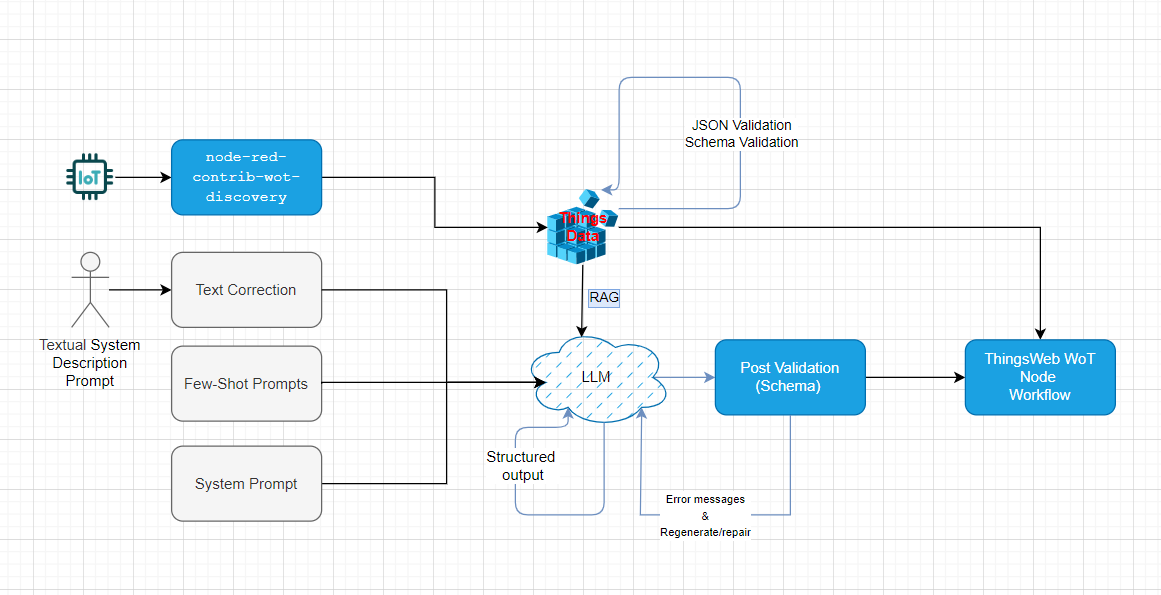